Seja a treliça isostática representada a seguir. As barras são tubulares, com diâmetro externo e espessura iguais a $D = 50\, \textrm{mm}$ e $t = 5\, \textrm{mm}$, respectivamente. Com base no Princípio dos Trabalhos Virtuais, ou método equivalente, obter a equação do deslocamento vertical no ponto C ($\delta_{C}$).

![](./images/Imagem1.png)

Admita-se que as forças $P$ e $Q$, e o módulo de elasticidade do aço ($E$) são variáveis aleatórias (v.a.) no processo (vide Tabela 1). Ainda que não se possa definir de forma exata o modelo estatístico que rege a v.a. $\delta_{C}$, pode-se inferir a respeito de sua distribuição com base em simulação. Assim, deve-se gerar séries de números randômicos para E, P e Q, obtendo-se uma série de dados simulados para $\delta_{C}$. Com base na análise de seu histograma e em um teste de aderência à escolha, deve-se verificar se os dados de $\delta_{C}$ são originados do modelo Lognormal.

Tabela 1 - Descrição estatística das v.a. do problema

| **Variável** | **Média** | **COV** | **Distribuição** |
|--------------|-----------|---------|------------------|
| $E$ (GPa)    | 205       | 0,05    | Normal           |
| $P$ (kN)     | 60        | 0,1     | Normal           |
| $Q$ (kN)     | 40        | 0,1     | Normal           |

# Resolução

## Expressão do deslocamento vertical no ponto C ($\delta_{C}$)

No arquivo `trelica_q2.pdf` é realizada a aplicação do Princípio dos Trabalhos Virtuais na treliça para o cálculo da expressão do deslocamento vertical no Ponto C, dada pela @eq-delta-c.

$$
\delta_{C} = \dfrac{4P + 14Q + 4 \sqrt{2} (P + 2Q)}{EA} 
$$ {#eq-delta-c}

## Inferência sobre a distribuição do deslocamento

Para inferir sobre a distribuição do deslocamento, foram gerados 50000 pontos randomicamente baseados nas distribuições da Tabela 1 para $E$, $P$ e $Q$. Para isso, foi utilizada a linguagem [Python](https://python.org/) e a biblioteca [NumPy](https://numpy.org), conforme é apresentado no código abaixo.

In [2]:
#| code-fold: false


import numpy as np

SIZE = 50_000
np.random.seed(0)

mu_E = 205.0e9  # Pa
COV_E = 0.05
sigma_E = COV_E * mu_E

mu_P = 60.0e3  # N
COV_P = 0.1
sigma_P = COV_P * mu_P

mu_Q = 40.0e3  # N
COV_Q = 0.1
sigma_Q = COV_Q * mu_Q

De = 50e-3  # m
t = 5e-3  # m
A = np.pi * (De**2 - (De - 2 * t) ** 2) / 4  # m^2


def calc_delta_C(P, Q, E, A):
    return (4 * P + 14 * Q + 4 * np.sqrt(2) * (P + 2 * Q)) / (E * A)


E_values = np.random.normal(mu_E, sigma_E, SIZE)
P_values = np.random.normal(mu_P, sigma_P, SIZE)
Q_values = np.random.normal(mu_Q, sigma_Q, SIZE)

delta_C_values = calc_delta_C(P_values, Q_values, E_values, A) * 1E2  # cm

Um histograma de densidade de probabilidade é apresentado na @fig-hist-q2. A construção desse histograma foi feita por meio da biblioteca [Seaborn](https://seaborn.pydata.org/).

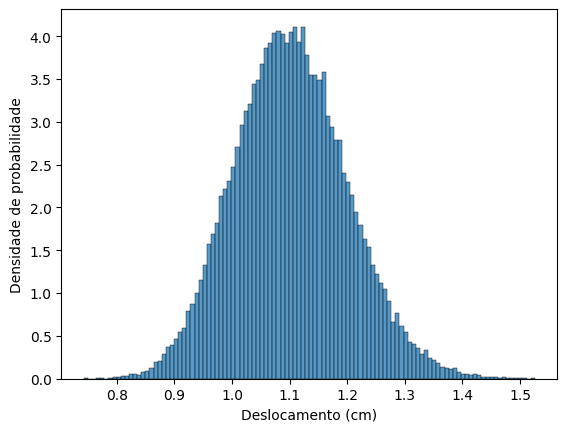

In [3]:
#| label: fig-hist-q2
#| fig-cap: Histograma de densidade de probabilidade do deslocamento vertical no ponto C.

import seaborn as sns


fig = sns.histplot(data=delta_C_values, stat="density")
fig.set_xlabel("Deslocamento (cm)")
fig.set_ylabel("Densidade de probabilidade");

Para obter os parâmetros desses dados para a distribuição Lognormal, utilizamos a biblioteca [SciPy](https://scipy.org/).

In [4]:
#| code-fold: false

import scipy.stats as ss

s, loc, scale = ss.lognorm.fit(delta_C_values)

Adaptou-se a implementação do teste de Kolmogorov-Smirnov feito na Questão 1 para utilizá-lo nessa questão.

In [5]:
import matplotlib.pyplot as plt

def calculate_ks_test(data: np.array, ecdf, distribution, **parameters):
    min_value = data.min()
    max_value = data.max()
    step = (max_value - min_value) / 1e5

    x_range = np.arange(min_value, max_value + step, step)

    ks_test_value = 0
    x_ks_test = min_value

    for xi in x_range:
        ks = abs(ecdf.evaluate(xi) - distribution.cdf(xi, **parameters))
        if ks > ks_test_value:
            ks_test_value = ks
            x_ks_test = xi

    return ks_test_value, x_ks_test


def plot_ks_test(
    ecdf, distribution, x_ks_value, ks_test_value, save=False, xytext=None, **parameters
):
    fig, ax = plt.subplots()
    x_plot = np.linspace(
        distribution.ppf(0.001, **parameters),
        distribution.ppf(0.999, **parameters),
        1000,
    )
    ax.plot(x_plot, distribution.cdf(x_plot, **parameters), label="CDF")
    ecdf.plot(ax=ax, label="ECDF (Empírica)")
    ax.plot(
        [x_ks_value, x_ks_value],
        [
            distribution.cdf(x_ks_value, **parameters),
            ecdf.evaluate(x_ks_value),
        ],
        "k+-",
    )
    ax.set_xlabel("Deslocamento (cm)")
    ax.set_ylabel("Função cumulativa")
    ax.legend(loc="best")
    ax.annotate(
        f"ks = {ks_test_value:.5f}",
        (x_ks_value, ecdf.evaluate(x_ks_value) + 0.05),
        xytext=(x_ks_value + 1, ecdf.evaluate(x_ks_value) + 0.05)
        if xytext is None
        else xytext,
    )
    ax.grid(True, color="gray", alpha=0.15)
    if save:
        fig.savefig("ks-test.pdf", bbox_inches="tight")

Na @fig-ks-test é representado o teste de Kolmogorov-Smirnov baseado na implementação apresentada para a distribuição Lognormal.

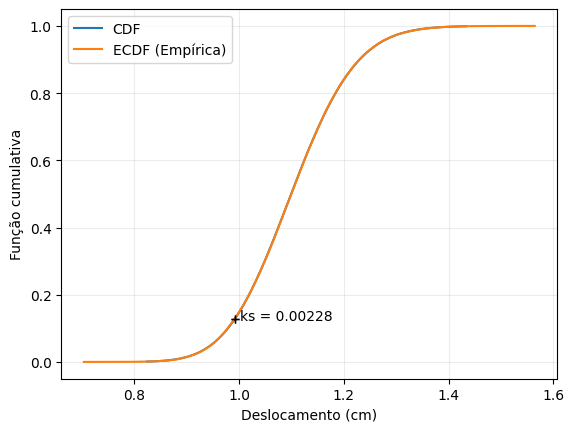

In [6]:
#| label: fig-ks-test
#| fig-cap: Teste de Kolmogorov-Smirnov para a distribuição Lognormal ajustada aos dados.

ecdf = ss.ecdf(delta_C_values).cdf

ks_test_value, x_ks_value = calculate_ks_test(delta_C_values, ecdf, ss.lognorm, s=s, loc=loc, scale=scale)
plot_ks_test(
    ecdf,
    ss.lognorm,
    x_ks_value,
    ks_test_value,
    s=s,
    loc=loc,
    scale=scale,
    xytext=(x_ks_value + 0.01, ecdf.evaluate(x_ks_value) - 0.005),
)

Na tabela abaixo são comparados os valores obtidos com a implementação desenvolvida com os obtidos por meio da função `kstest`.

In [7]:
import pandas as pd


ks_res_lognormal = ss.kstest(delta_C_values, "lognorm", args=(s, loc, scale))

df_ks_gauss = pd.DataFrame(
    [
        {"ks": ks_test_value, "Location": x_ks_value},
        {"ks": ks_res_lognormal.statistic, "Location": ks_res_lognormal.statistic_location},
    ]
)
df_ks_gauss.index = ["Manual", "Scipy"]
df_ks_gauss

,ks,Location
Manual,0.002277,0.991496
Scipy,0.002284,0.991493


Considerando um nível de significância ($\alpha$) de 5%, podemos calcular o valor crítico do teste.

In [8]:
#| code-fold: false
ks_critical_value = 1.36 / np.sqrt(SIZE)
ks_critical_value

0.006082104898799429

Uma vez que o valor calculado (**0,0023**) foi menor que o crítico (**0,0061**), verificamos que, para esse nível de significância, podemos admitir que os dados testados são originados do modelo Lognormal.